# Wind Turbine Power Production
###  Project assessment
#### [Machine Learning and Statistics Module GMIT 2020 ]

---

<img align="left" width="300" src="https://image.flaticon.com/icons/png/512/1778/1778210.png">
<br>

<br>

Lecturer: *Ian McLoughlin (https://github.com/ianmcloughlin)*

Completed by: *Olga Rozhdestvina (G00387844@gmit.ie)*

---

## Table of Contents

* [Overview](#overview)
* [General Setup](#setup)
* [Loading Data](#loading_data)
* [](#)
* [](#)
* [](#)
* [](#)

<br>

### Overview <a name="overview"></a>
___

<br>

### General Setup <a name="setup"></a>
___

In [1]:
# Neural networks.
import tensorflow.keras as kr

# Preprocessing
from sklearn.model_selection import train_test_split as tts
import sklearn.linear_model as md
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Numerical arrays.
import numpy as np

# Data frames.
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt
# Another package for plotting.
import seaborn as sns

%matplotlib inline

In [2]:
# Theme for plots.
sns.set_theme(palette="Set2", context="paper", font_scale=1.5, )

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

<br>

### Loading Data <a name="loading_data"></a>
___

> [1] [Adjusting Size of Seaborn Plot](https://stackoverflow.com/questions/51502927/adjusting-size-of-seaborn-plot)

In [3]:
# Load the iris data set from a URL.
df = pd.read_csv("powerproduction.csv")

# Display the data frame.
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


In [4]:
# Check for empty values.
df.isnull().values.any()

False

In [5]:
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


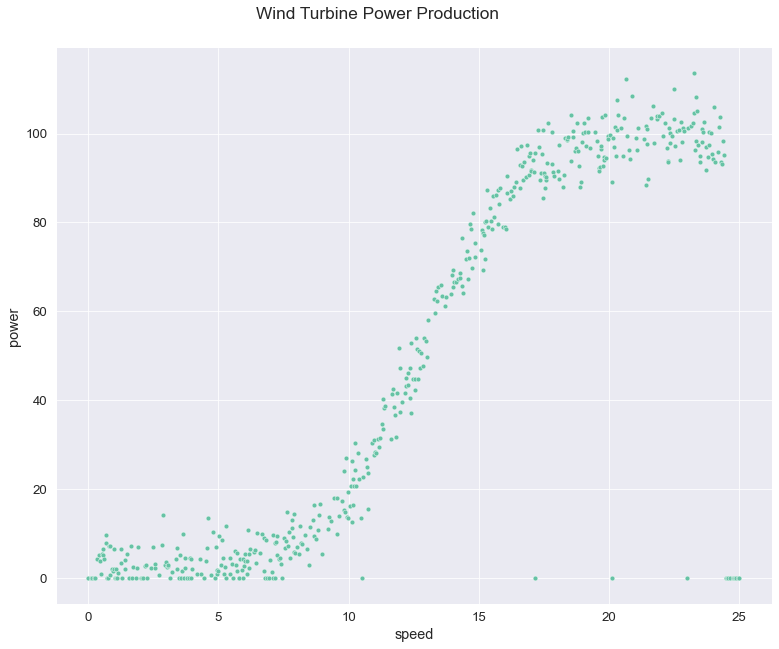

In [6]:
# Plot data.
sns.relplot(data=df, x="speed", y="power")

# Change plot size.
fig = plt.gcf()
fig.set_size_inches(12, 9)
fig.suptitle("Wind Turbine Power Production", y=1.02)

# Show the plot.
plt.show()

The above plot shows that the data follows a non-linear model. The relationship between Power and Speed predominantly take "S"-shape (sigmoid curve). The power rises dramatically with speed over about 8 m/s and slows when the speed reaches about 17 m/s.

Additionally, we can see some outliners where the speed is above 10 m/s, however, the power is still 0.

<br>

###  Data Pre-processing.
___

The first step is to remove those outliners from our data set. [2]

> [2] [Delete rows based on multiple conditions; including other column conditionals](https://stackoverflow.com/questions/31997992/delete-rows-based-on-multiple-conditions-including-other-column-conditionals)

In [7]:
df_new = df.drop(df[(df.power == 0) & (df.speed > 5)].index)
df_new

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
...,...,...
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223


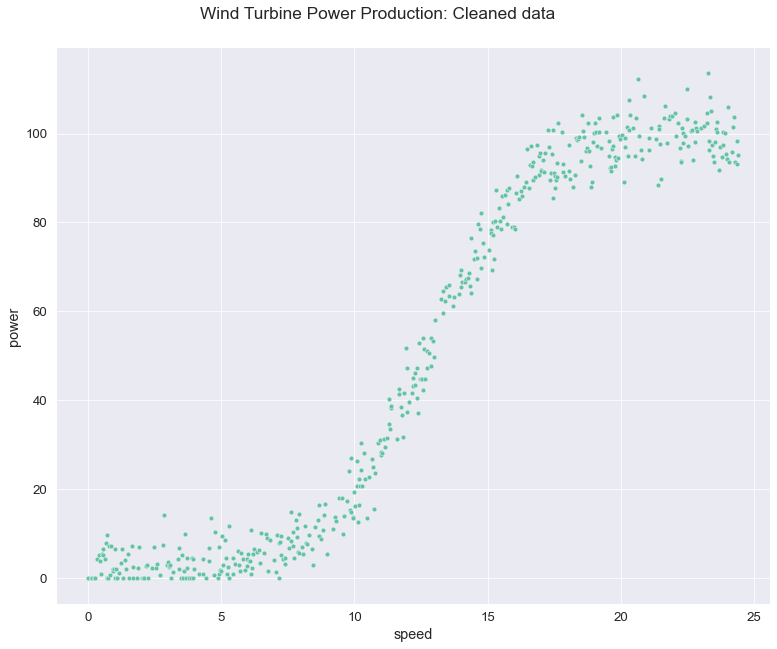

In [8]:
# Plot data.
sns.relplot(data=df_new, x="speed", y="power")

# Change plot size.
fig = plt.gcf()
fig.set_size_inches(12, 9)
fig.suptitle("Wind Turbine Power Production: Cleaned data", y=1.02)

# Show the plot.
plt.show()

In [9]:
# Separate speed from power.
speed = df_new.iloc[:, 0].values
power = df_new.iloc[:, 1].values

# Convert them into a numpy array.
X = np.array(speed).reshape(-1,1)
y = np.array(power)

Finally, since we have Polynomial regression we can apply PolynomialFeatures.

>[3] [Polynomial interpolation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py)

In [10]:
# Find the best degree.
for degree in range(1,6):
    model = make_pipeline(PolynomialFeatures(degree), md.Ridge())
    model.fit(X, y)
    print(f'{degree}: {model.score(X,y)}')

1: 0.903329459488843
2: 0.9051962906190765
3: 0.9785336368530014
4: 0.9798972502580137
5: 0.988364899815888


The results show that the 5 degrees give the best results. Let's first plot it and then apply it to the speed data.

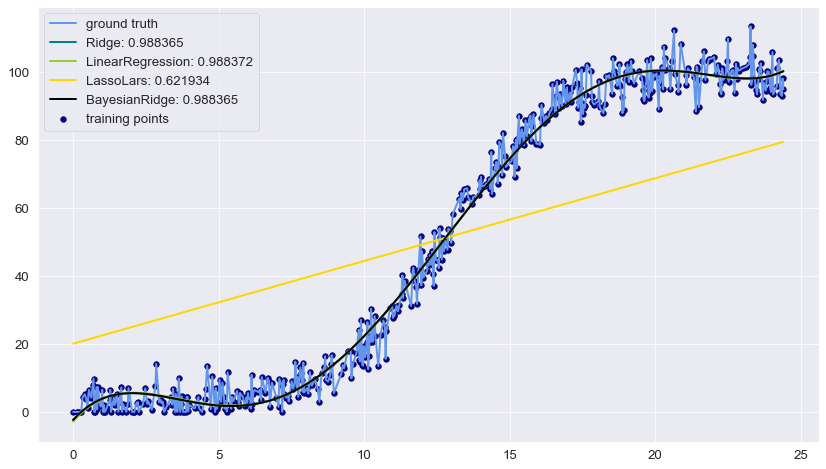

In [11]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot training points and line connecting them.
ax.plot(X, y, color='cornflowerblue', linewidth=2, label="ground truth")
ax.scatter(X, y, color='navy', s=30, marker='o', label="training points")

# List of available linear models working
models = ["Ridge", "LinearRegression", "LassoLars", "BayesianRidge"]

# Create a pipeline
colors = ['teal', 'yellowgreen', 'gold', "black","red"]

for count, i in enumerate(models):
    model = getattr(md, i)
    # Create a pipeline
    poly_model = make_pipeline(PolynomialFeatures(5), model())
    poly_model.fit(X, y)
    y_pred = poly_model.predict(X)

    # Plot predictions.x,y
    ax.plot(X, y_pred, color=colors[count], linewidth=2, label=f"{i}: {poly_model.score(X,y):.6f}")
    
# Show legend.
plt.legend(loc='upper left')

# Show the plot.
plt.show()

We can see from the above scores that Ridge, Linear Regression and Lasso Lars models perform almost identically, however, Linear Regression outperforms the others by 0.00001.

In [12]:
# Split data on training and test (add random state so the outputs are the same after each execution).
speed_train, speed_test, power_train, power_test = tts(X, y, test_size=0.3, random_state=1)

<br>

### Sklearn
___

Next we need to split the data set into training and testing data. 

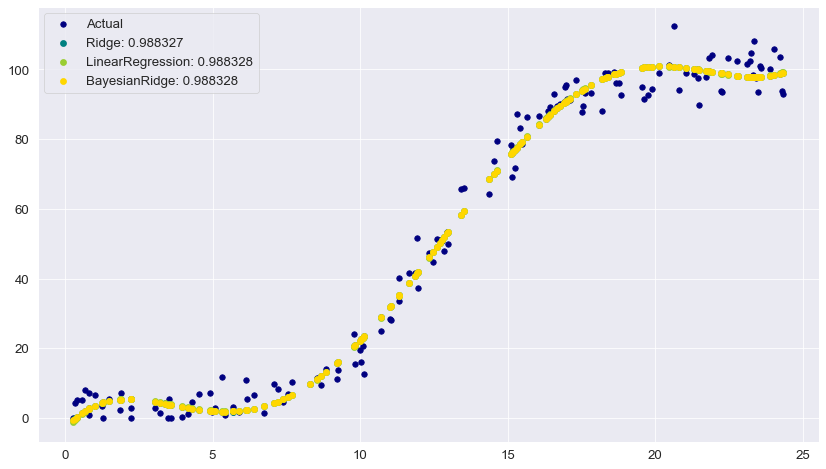

In [13]:
# Create a figure and axis
fig, ax = plt.subplots()

# Actual test data.
ax.scatter(speed_test, power_test, color='navy', s=30, marker='o', label="Actual")

# List of available linear models working
models = ["Ridge", "LinearRegression", "BayesianRidge"]

# Create a pipeline
colors = ['teal', 'yellowgreen', 'gold', "black","red"]


for count, i in enumerate(models):
    model = getattr(md, i)
    poly_model = make_pipeline(PolynomialFeatures(5), model())
    # Create a pipeline
    poly_model.fit(speed_train, power_train)
    y_pred = poly_model.predict(speed_test)

    # Plot predictions.x,y
    ax.scatter(speed_test, y_pred, color=colors[count], linewidth=2, label=f"{i}: {poly_model.score(X,y):.6f}")
# Show legend.
plt.legend(loc='upper left')

# Show the plot.
plt.show()

In [14]:
poly = PolynomialFeatures(5)
new_df = poly.fit_transform(df_new)
#convert the array back to a dataframe
dataset = pd.DataFrame(new_df)
# summarize
print(dataset.shape)

(477, 21)


<br>

### Neural Networks.
___


In [15]:
# Train a different model.
model = kr.models.Sequential()
model.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile("adam", loss='mse')

In [16]:
# Train the neural network on our training data.
model.fit(speed_train, power_train, epochs=400)

Epoch 1/400
11/11 [==============================] - 2s 4ms/step - loss: 4108.5112
Epoch 2/400
11/11 [==============================] - 0s 5ms/step - loss: 3921.3658
Epoch 3/400
11/11 [==============================] - 0s 5ms/step - loss: 3827.6079
Epoch 4/400
11/11 [==============================] - 0s 4ms/step - loss: 4069.5274
Epoch 5/400
11/11 [==============================] - 0s 5ms/step - loss: 3947.9999
Epoch 6/400
11/11 [==============================] - 0s 6ms/step - loss: 3728.7421
Epoch 7/400
11/11 [==============================] - 0s 4ms/step - loss: 3673.5997
Epoch 8/400
11/11 [==============================] - 0s 4ms/step - loss: 3801.1873
Epoch 9/400
11/11 [==============================] - 0s 3ms/step - loss: 3398.8306
Epoch 10/400
11/11 [==============================] - 0s 4ms/step - loss: 3656.5719
Epoch 11/400
11/11 [==============================] - 0s 4ms/step - loss: 3575.6992
Epoch 12/400
11/11 [==============================] - 0s 4ms/step - loss: 3535.4090
E

11/11 [==============================] - 0s 4ms/step - loss: 1505.6315
Epoch 99/400
11/11 [==============================] - 0s 4ms/step - loss: 1395.4056
Epoch 100/400
11/11 [==============================] - 0s 4ms/step - loss: 1422.3727
Epoch 101/400
11/11 [==============================] - 0s 5ms/step - loss: 1507.1683
Epoch 102/400
11/11 [==============================] - 0s 4ms/step - loss: 1398.5499
Epoch 103/400
11/11 [==============================] - 0s 4ms/step - loss: 1422.5432
Epoch 104/400
11/11 [==============================] - 0s 4ms/step - loss: 1280.6216
Epoch 105/400
11/11 [==============================] - 0s 4ms/step - loss: 1329.8208
Epoch 106/400
11/11 [==============================] - 0s 4ms/step - loss: 1310.7590
Epoch 107/400
11/11 [==============================] - 0s 4ms/step - loss: 1326.7975
Epoch 108/400
11/11 [==============================] - 0s 5ms/step - loss: 1338.0875
Epoch 109/400
11/11 [==============================] - 0s 5ms/step - loss: 1289.

11/11 [==============================] - 0s 5ms/step - loss: 564.7587
Epoch 195/400
11/11 [==============================] - 0s 5ms/step - loss: 556.6734
Epoch 196/400
11/11 [==============================] - 0s 5ms/step - loss: 560.3254
Epoch 197/400
11/11 [==============================] - 0s 4ms/step - loss: 590.0295
Epoch 198/400
11/11 [==============================] - 0s 5ms/step - loss: 559.7935
Epoch 199/400
11/11 [==============================] - 0s 5ms/step - loss: 551.8298
Epoch 200/400
11/11 [==============================] - 0s 6ms/step - loss: 555.8667
Epoch 201/400
11/11 [==============================] - 0s 4ms/step - loss: 565.7224
Epoch 202/400
11/11 [==============================] - 0s 4ms/step - loss: 559.0010
Epoch 203/400
11/11 [==============================] - 0s 4ms/step - loss: 506.7609
Epoch 204/400
11/11 [==============================] - 0s 4ms/step - loss: 513.7306
Epoch 205/400
11/11 [==============================] - 0s 4ms/step - loss: 558.5704
Epoch 

11/11 [==============================] - 0s 3ms/step - loss: 211.0489
Epoch 292/400
11/11 [==============================] - 0s 3ms/step - loss: 218.4745
Epoch 293/400
11/11 [==============================] - 0s 4ms/step - loss: 213.9552
Epoch 294/400
11/11 [==============================] - 0s 4ms/step - loss: 210.9924
Epoch 295/400
11/11 [==============================] - 0s 4ms/step - loss: 193.1800
Epoch 296/400
11/11 [==============================] - 0s 4ms/step - loss: 212.7295
Epoch 297/400
11/11 [==============================] - 0s 4ms/step - loss: 190.2612
Epoch 298/400
11/11 [==============================] - 0s 6ms/step - loss: 189.3611
Epoch 299/400
11/11 [==============================] - 0s 6ms/step - loss: 197.3349
Epoch 300/400
11/11 [==============================] - 0s 6ms/step - loss: 211.4200
Epoch 301/400
11/11 [==============================] - 0s 5ms/step - loss: 199.2963
Epoch 302/400
11/11 [==============================] - 0s 5ms/step - loss: 197.5182
Epoch 

11/11 [==============================] - 0s 4ms/step - loss: 96.0393
Epoch 389/400
11/11 [==============================] - 0s 4ms/step - loss: 102.1004
Epoch 390/400
11/11 [==============================] - 0s 4ms/step - loss: 97.5203
Epoch 391/400
11/11 [==============================] - 0s 4ms/step - loss: 102.7761
Epoch 392/400
11/11 [==============================] - 0s 4ms/step - loss: 93.6864
Epoch 393/400
11/11 [==============================] - 0s 4ms/step - loss: 97.1554
Epoch 394/400
11/11 [==============================] - 0s 4ms/step - loss: 90.2395
Epoch 395/400
11/11 [==============================] - 0s 4ms/step - loss: 89.1678
Epoch 396/400
11/11 [==============================] - 0s 4ms/step - loss: 93.3786
Epoch 397/400
11/11 [==============================] - 0s 4ms/step - loss: 96.5103
Epoch 398/400
11/11 [==============================] - 0s 4ms/step - loss: 91.2793
Epoch 399/400
11/11 [==============================] - 0s 4ms/step - loss: 87.8008
Epoch 400/400
11

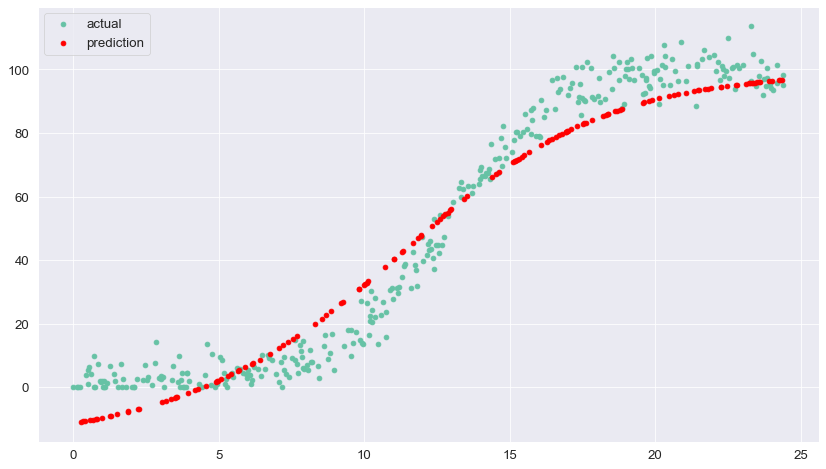

In [17]:

# Now let's see.
plt.scatter(speed_train, power_train, label='actual')
plt.scatter(speed_test, model.predict(speed_test), label='prediction', c="r")
plt.legend()
plt.show()